## Importing the relevant libraries

In [1]:
!pip install wget tensorflow==2.10.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, punct, remove_digits, remove_links, remove_special_characters, remove_, removeStopWords, lower, email_address, non_ascii
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model, get_custom_objects
from tensorflow.keras.losses import SparseCategoricalCrossentropy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the dataset

In [3]:
df = pd.read_csv('/content/Luxury_Products_Apparel_Data.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Category,SubCategory,ProductName,Description
0,Accessories,Bags,"""Prada Striped Shell Belt Bag""","""One of Prada's most functional designs, this ..."
1,Accessories,Socks,"""Falke - Lhasa Wool And Cashmere-blend Socks -...","""Falke - Casual yet luxurious, Falke's dark na..."
2,Suits,Tuxedos,"""peak lapel tuxedo suit jacket""","""White and black linen blend peak lapel tuxedo..."
3,Accessories,Gloves,"""Thom Browne Navy 4-Bar Rib Gloves""","""Pair of rib knit cashmere gloves in navy. Sig..."
4,Accessories,Cufflinks,"""Alice Made This - Bayley Round Patina-brass C...","""Alice Made This - Made in the UK, these teal ..."


## Data Exploration

In [4]:
df.shape

(5000, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     4963 non-null   object
 1   SubCategory  4963 non-null   object
 2   ProductName  5000 non-null   object
 3   Description  5000 non-null   object
dtypes: object(4)
memory usage: 156.4+ KB


In [6]:
df.describe()

,Category,SubCategory,ProductName,Description
count,4963,4963,5000,5000
unique,10,42,4388,4489
top,Accessories,Eyewear,"""Slide high-top sneakers""","""Dropship"""
freq,1277,344,11,5


In [7]:
df.isna().sum()

,0
Category,37
SubCategory,37
ProductName,0
Description,0


In [8]:
df = df.dropna()
df.shape

(4963, 4)

## Exploratory Data Analysis (EDA)

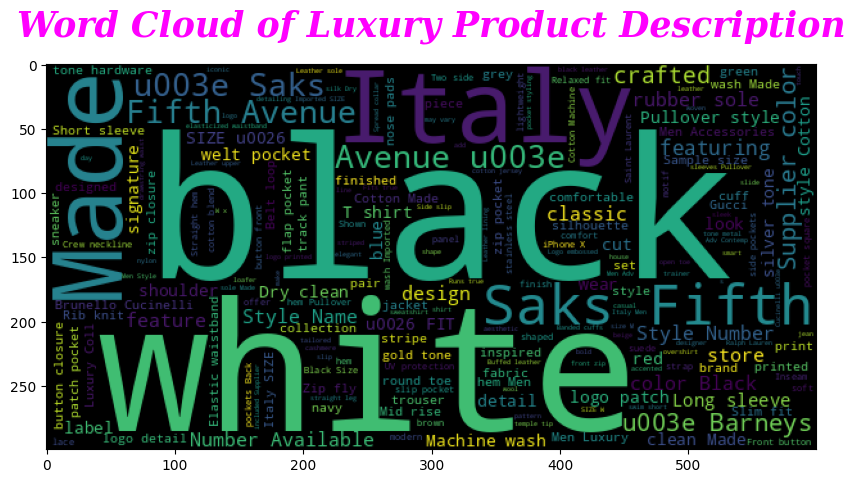

In [9]:
plt.figure(figsize=(11,5))
wc = WordCloud(width=600,height=300,random_state=101).generate(''.join(df.Description))
plt.title('Word Cloud of Luxury Product Description',fontsize=25,fontweight='bold',color='magenta',fontfamily='serif',fontstyle='italic',pad=20)
plt.imshow(wc);

In [10]:
df['num_words'] = df.Description.apply(len)
df.num_words.describe()

,num_words
count,4963.000000
mean,263.033045
std,155.335819
min,2.000000
25%,160.000000
50%,244.000000
75%,328.000000
max,1686.000000


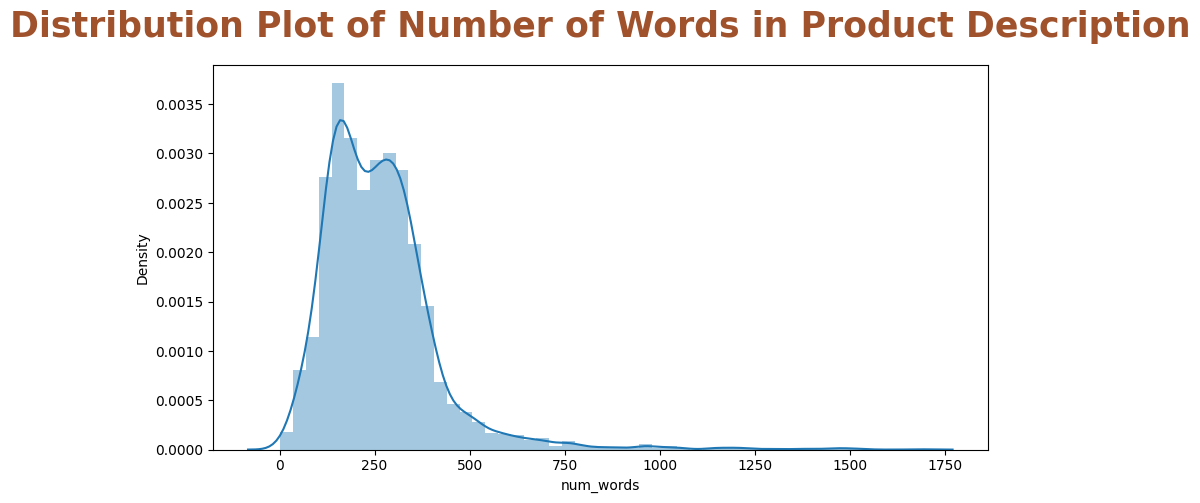

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(df['num_words'])
plt.title('Distribution Plot of Number of Words in Product Description',pad=20,fontsize=25,color='sienna',fontweight='bold')
plt.show();

In [12]:
max_len = 85

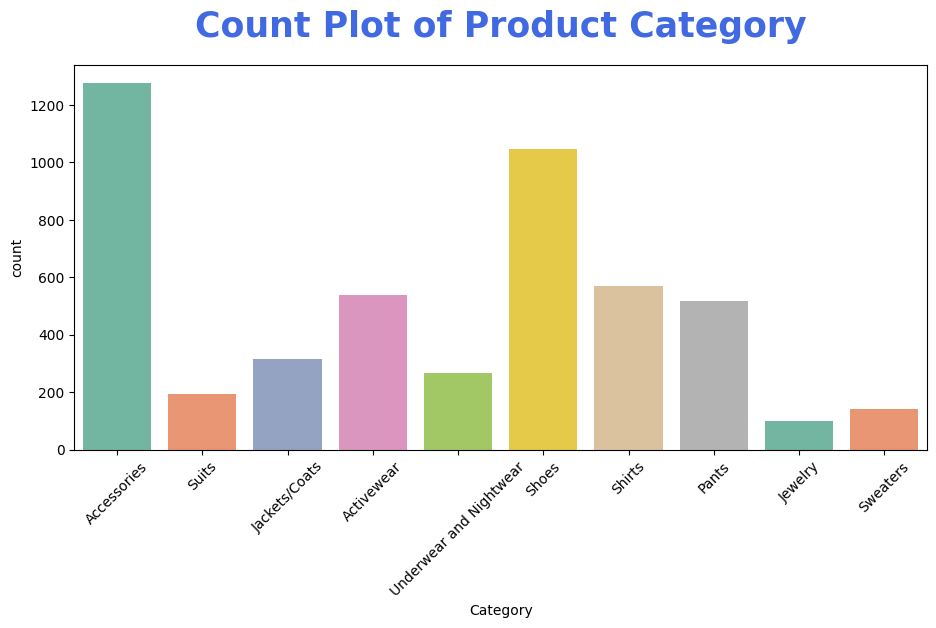

In [13]:
plt.figure(figsize=(11,5))
sns.countplot(x='Category',data=df,palette='Set2')
plt.xticks(rotation=45)
plt.title('Count Plot of Product Category',pad=20,fontsize=25,color='royalblue',fontweight='bold')
plt.show();

It's clearly evident that the target label is highly imbalanced.

## Preprocessing the text data

In [14]:
def preprocess_text(data,col):
    data[col] = data[col].apply(func=lower)
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    return data

In [15]:
preprocessed_df = preprocess_text(df,'Description')
preprocessed_df.head()

,Category,SubCategory,ProductName,Description,num_words
0,Accessories,Bags,"""Prada Striped Shell Belt Bag""",one prada functional designs belt bag made wea...,252
1,Accessories,Socks,"""Falke - Lhasa Wool And Cashmere-blend Socks -...",falke casual yet luxurious falke dark navy lha...,257
2,Suits,Tuxedos,"""peak lapel tuxedo suit jacket""",white black linen blend peak lapel tuxedo suit...,190
3,Accessories,Gloves,"""Thom Browne Navy 4-Bar Rib Gloves""",pair rib knit cashmere gloves navy signature s...,169
4,Accessories,Cufflinks,"""Alice Made This - Bayley Round Patina-brass C...",alice made made uk teal bayley cufflinks alice...,300


In [16]:
preprocessed_df['num_words'] = preprocessed_df.Description.apply(len)
preprocessed_df.num_words.describe()

,num_words
count,4963.000000
mean,209.143260
std,119.784678
min,0.000000
25%,131.000000
50%,193.000000
75%,256.000000
max,1328.000000


## Splitting the processed dataset into train and test sets

In [17]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.2,shuffle=True,random_state=101,stratify=preprocessed_df['Category'])

In [18]:
train_df.shape, test_df.shape

((3970, 5), (993, 5))

## Encoding the target label

In [19]:
encoder = LabelEncoder()
train_df.Category = encoder.fit_transform(train_df.Category)
test_df.Category = encoder.transform(test_df.Category)

## Loading the pretrained Distilbert Tokenizer and model from Hugging Face

In [20]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
distilbert_model = TFAutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## Text Tokenization

In [21]:
X_train = tokenizer(text=train_df['Description'].tolist(),
                    max_length=max_len,
                    padding=True,
                    truncation=True,
                    add_special_tokens=True,
                    return_token_type_ids=False,
                    return_attention_mask=True,
                    return_tensors='tf',
                    verbose=1
                   )

X_test = tokenizer(text=test_df['Description'].tolist(),
                    max_length=max_len,
                    padding=True,
                    truncation=True,
                    add_special_tokens=True,
                    return_token_type_ids=False,
                    return_attention_mask=True,
                    return_tensors='tf',
                    verbose=1
                   )

## Defining fine-tuned DistilBERT model architecture

In [22]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [23]:
embeddings = distilbert_model(input_ids=input_ids,attention_mask=attention_mask)[0] # 0 -> final hidden state, 1 -> final pooling output
output = Flatten()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=64,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=32,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.1)(output)
output = Dense(units=10,activation='softmax')(output)
model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 85)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 2),                                                 
                                 hidden_states=None                                           

## Visualizing the model architecture

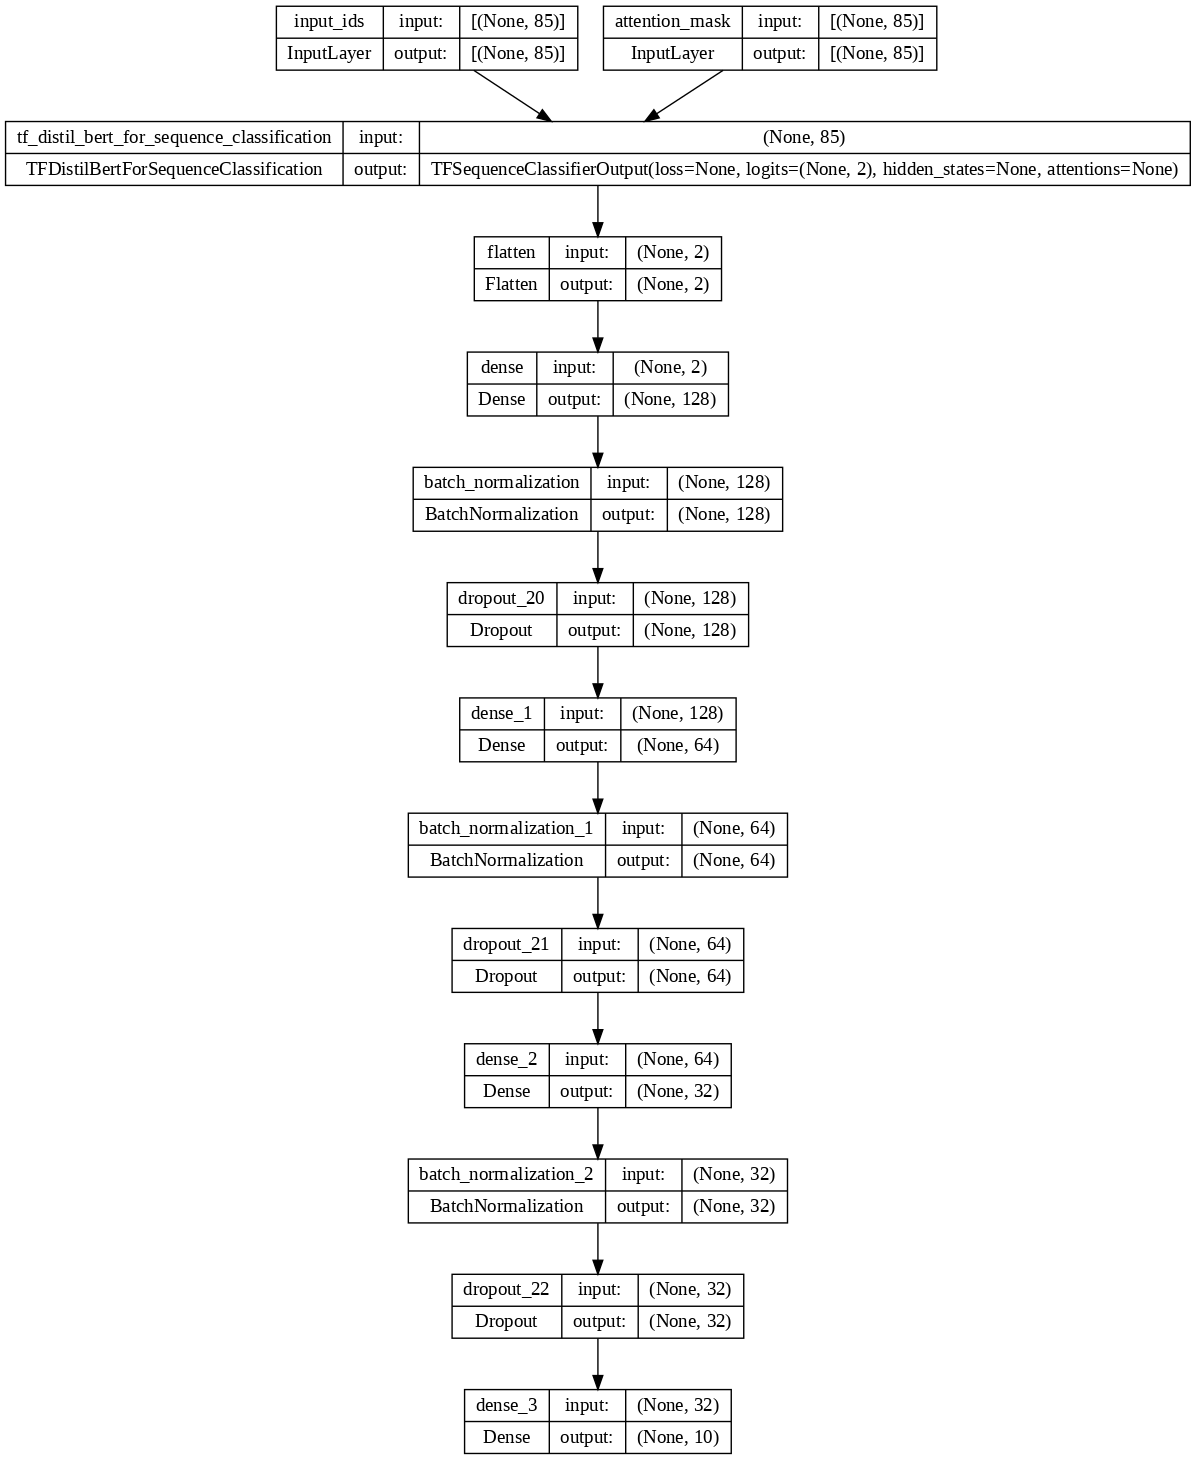

In [24]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100,rankdir='TB')

In [25]:
adam = AdamW(learning_rate=5e-5, epsilon=1e-8, weight_decay=1e-2, clipnorm=1.0)
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer=adam, metrics=['sparse_categorical_accuracy'])

In [26]:
def cosine_annealing(epoch, lr):
    """Cosine annealing learning rate scheduler with warm restarts.

    # Arguments
        epoch: int. epoch number.
        lr: float. previous learning rate.

    # Returns
        lr: float. updated learning rate.
    """
    max_lr = 5e-5
    min_lr = 1e-6
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / 25))

In [27]:
# Determining balanced class weights for all classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df.Category),
    y=train_df.Category
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.38883447600391774,
 1: 0.9232558139534883,
 2: 1.5753968253968254,
 3: 5.025316455696203,
 4: 0.9612590799031477,
 5: 0.8725274725274725,
 6: 0.4737470167064439,
 7: 2.5448717948717947,
 8: 3.5132743362831858,
 9: 1.863849765258216}

## Training the fine-tuned DistilBERT model

In [ ]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy',mode='max',patience=10,restore_best_weights=True,verbose=1)
mc = ModelCheckpoint(filepath='luxury_apparel_product_category_classifier.keras',
                    monitor='val_sparse_categorical_accuracy',
                    mode='max',
                    save_best_only=True,
                    save_freq='epoch',
                    verbose=1)
lr = LearningRateScheduler(schedule=cosine_annealing,verbose=1)
tb = TensorBoard(log_dir='logs',histogram_freq=1,write_graph=True,update_freq='epoch')

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=train_df.Category,
              epochs=56,
              batch_size=64,
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category),
              callbacks=[es,lr,mc,tb],
              class_weight=class_weights_dict
             )


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/56
63/63 [==============================] - ETA: 0s - loss: 2.8710 - sparse_categorical_accuracy: 0.0907
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.11480, saving model to luxury_apparel_product_category_classifier.keras
63/63 [==============================] - 611s 9s/step - loss: 2.8710 - sparse_categorical_accuracy: 0.0907 - val_loss: 2.3060 - val_sparse_categorical_accuracy: 0.1148 - lr: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.9806810182204715e-05.
Epoch 2/56
63/63 [==============================] - ETA: 0s - loss: 2.7611 - sparse_categorical_accuracy: 0.0851
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.11480
63/63 [==============================] - 585s 9s/step - loss: 2.7611 - sparse_categorical_accuracy: 0.0851 - val_loss: 2.2855 - val_sparse_categorical_accuracy: 0.1148 - lr: 4.9807e-05

Epoch 3: LearningRateScheduler setting learning rat

## Visualizing model performance

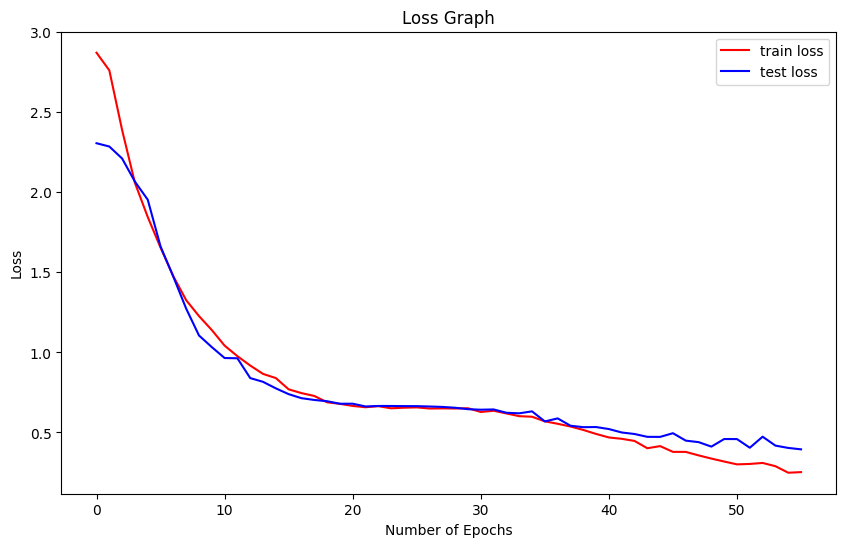

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

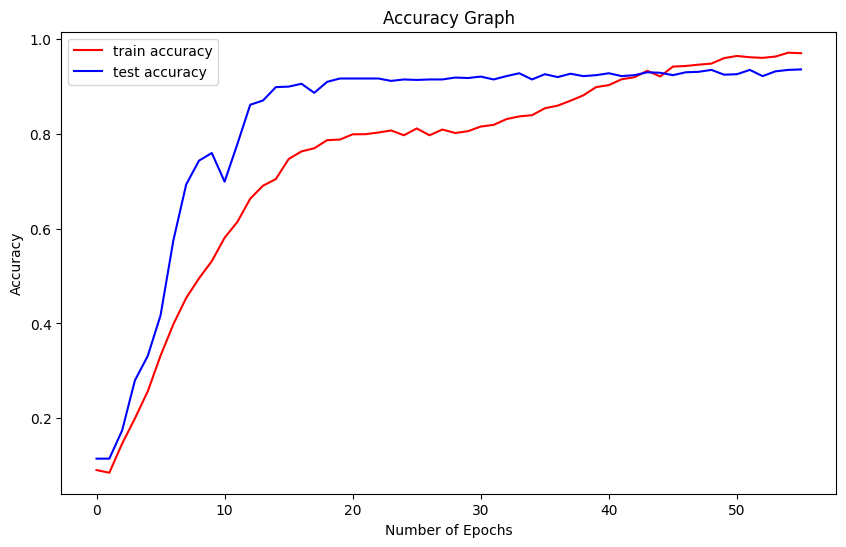

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(r.history['sparse_categorical_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_sparse_categorical_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Model Evaluation

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'],'attention_mask': X_test['attention_mask']},test_df.Category)
print("Test Sparse Categorical Crossentropy Loss:", round(loss,2))
print("Test Sparse Categorical Accuracy:", round(acc*100,2))

32/32 [==============================] - 36s 1s/step - loss: 0.3948 - sparse_categorical_accuracy: 0.9355
Test Sparse Categorical Crossentropy Loss: 0.39
Test Sparse Categorical Accuracy: 93.55


## Saving the pretrained Tokenizer

In [28]:
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## Loading the saved model

In [29]:
# Register the custom object
get_custom_objects()["TFDistilBertForSequenceClassification"] = distilbert_model

In [30]:
loaded_model = load_model('/content/luxury_apparel_product_category_classifier.keras')
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 85)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_ids[0][0]',              
 assification_1 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 2),                                                 
                                 hidden_states=None                                           

## Making predictions on test data

Confusion Matrix:
[[249   1   1   2   0   0   2   0   0   1]
 [  2  92   1   0   3   5   0   1   2   1]
 [  3   3  52   0   0   2   0   2   1   0]
 [  1   0   0  19   0   0   0   0   0   0]
 [  0   5   1   0  89   4   0   0   0   4]
 [  0   1   1   0   2 110   0   0   0   0]
 [  3   0   0   0   1   0 204   0   1   1]
 [  0   1   1   0   0   0   0  37   0   0]
 [  0   0   3   0   0   0   0   0  25   0]
 [  0   0   0   0   1   0   0   0   0  52]]
--------------------------------------------------------------------------------


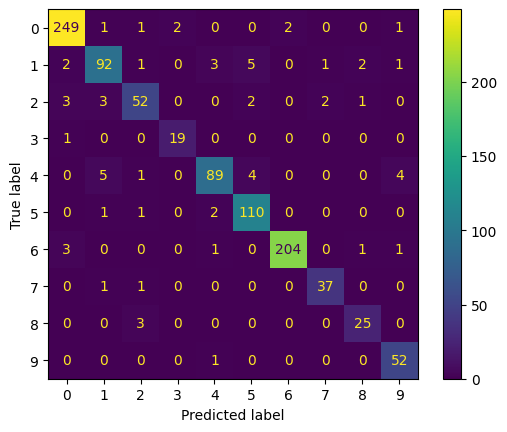

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       256
           1       0.89      0.86      0.88       107
           2       0.87      0.83      0.85        63
           3       0.90      0.95      0.93        20
           4       0.93      0.86      0.89       103
           5       0.91      0.96      0.94       114
           6       0.99      0.97      0.98       210
           7       0.93      0.95      0.94        39
           8       0.86      0.89      0.88        28
           9       0.88      0.98      0.93        53

    accuracy                           0.94       993
   macro avg       0.91      0.92      0.92       993
weighted avg       0.94      0.94      0.94       993

--------------------------------------------------------------------------------


In [31]:
test_predictions = loaded_model.predict({'input_ids': X_test['input_ids'],'attention_mask': X_test['attention_mask']},verbose=0)
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Category,test_predictions))
print("--"*40)
ConfusionMatrixDisplay.from_predictions(test_df.Category,test_predictions)
plt.show()
print("--"*40)
print("Classification Report:")
print(classification_report(test_df.Category,test_predictions))
print("--"*40)

## Model Inference

In [32]:
encoded_labels_dict = dict()

for idx, label in enumerate(encoder.classes_):
  encoded_labels_dict[idx] = label

encoded_labels_dict

{0: 'Accessories',
 1: 'Activewear',
 2: 'Jackets/Coats',
 3: 'Jewelry',
 4: 'Pants',
 5: 'Shirts',
 6: 'Shoes',
 7: 'Suits',
 8: 'Sweaters',
 9: 'Underwear and Nightwear'}

In [39]:
texts = [
    "Bridge width: 21mm, temple length: 145mm. Acetate frame with metal accents and logo detail on the temple. Lens category: 3 with 100% UV protection. Size: 51mm.",
    "12oz denim with a front button closure, featuring a self-tie flat lace belt. Intentionally distressed and faded details (may vary). Includes five pockets, skinny fit design, 93cm length, and 14cm hem.",
    "Gucci's Dive watch, crafted in Switzerland with a polished stainless steel frame, features a green and red Web-striped strap, luminescent hands, and markers on a flawless ETA quartz face, showcasing world-class timepiece craftsmanship.",
    "Puma x Rhude track pants featuring contrast stripe detailing. Designed with a drawstring front and elastic waistband for a secure fit. Equipped with side slip pockets for convenience. Pull-on style with a blend of polyester and cotton. Imported.",
    "Achieve a timeless, classic look with this cotton overshirt from Ami. Featuring a sturdy, straight-cut design, it offers both warmth and a strong, masculine aesthetic."
]

# Tokenize the texts
encoded_inputs = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='tf'
    )

# Extract input ids and attention masks
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Make predictions
predictions = loaded_model.predict({"input_ids": input_ids, "attention_mask": attention_mask},verbose=0)
predictions = np.argmax(predictions,axis=1)
predictions = predictions.tolist()
predictions = [encoded_labels_dict[pred] for pred in predictions]

for idx, pred in enumerate(predictions):
  print(f"Text: {texts[idx]}\nPredicted Category: {pred}\n")

Text: Bridge width: 21mm, temple length: 145mm. Acetate frame with metal accents and logo detail on the temple. Lens category: 3 with 100% UV protection. Size: 51mm.
Predicted Category: Accessories

Text: 12oz denim with a front button closure, featuring a self-tie flat lace belt. Intentionally distressed and faded details (may vary). Includes five pockets, skinny fit design, 93cm length, and 14cm hem.
Predicted Category: Pants

Text: Gucci's Dive watch, crafted in Switzerland with a polished stainless steel frame, features a green and red Web-striped strap, luminescent hands, and markers on a flawless ETA quartz face, showcasing world-class timepiece craftsmanship.
Predicted Category: Jewelry

Text: Puma x Rhude track pants featuring contrast stripe detailing. Designed with a drawstring front and elastic waistband for a secure fit. Equipped with side slip pockets for convenience. Pull-on style with a blend of polyester and cotton. Imported.
Predicted Category: Activewear

Text: Achiev